In [1]:
import pdb
from os import environ
environ['OMP_NUM_THREADS'] = '1'
#environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax
import jax.numpy as jnp
import numpy as np
import diffrax
import sys
import argparse
import pymc_experimental as pmx
import arviz as az

sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

sys.path.append("../")
from sampling_utils import *

# tell jax to use 64bit floats
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'birtwistle_2007'
free_params  = 'Kmf52,koff57,EGF_off,kcat90,koff91,koff40,koff88,koff95,kon91,kcat94,koff42,kon93,kcat92,koff46,kcon49,koff41,Vmaxr52,koff44,kon89,kon95'
data_file = '../../../results/MAPK/HF_96_synthetic_data.csv' 
nsamples = 40
savedir  = '../../../results/MAPK/param_est/'
input_state  = 'E' 
EGF_conversion_factor = 1 
ERK_states = 'ERKstar'
prior_family = "[['LogNormal(mu=6.3015942750942955)',['sigma']],['LogNormal(mu=-0.7927465457827001)',['sigma']],['LogNormal(mu=-4.045554398052669)',['sigma']], ['LogNormal(mu=2.995917256443601)',['sigma']],['LogNormal(mu=4.60515318584359)',['sigma']],['LogNormal(mu=1.1330459209859989)',['sigma']],['LogNormal(mu=1.367493731656173)',['sigma']],['LogNormal(mu=4.6051931857235955)',['sigma']],['LogNormal(mu=-1.626584071269071)',['sigma']],['LogNormal(mu=-0.003405793134832821)',['sigma']],['LogNormal(mu=1.2583189340660492)',['sigma']],['LogNormal(mu=-1.6079390363103645)',['sigma']],['LogNormal(mu=-1.6074399097714274)',['sigma']],['LogNormal(mu=-0.655080979753489)',['sigma']],['LogNormal(mu=2.3004127351323884)',['sigma']],['LogNormal(mu=1.9528432026578095)',['sigma']],['LogNormal(mu=5.294697322086547)',['sigma']], ['LogNormal(mu=-0.8521429120504033)',['sigma']],['LogNormal(mu=-1.6109390385603677)',['sigma']],['LogNormal(mu=-1.6129440517633882)',['sigma']]]"
t1 = 10000

In [3]:
print('Processing model {}.'.format(model_name))

# try calling the model
try:
    model = eval(model_name + '(transient=False)')
except:
    print('Warning Model {} not found. Skipping this.'.format(model_name))

# get parameter names and initial conditions
p_dict, plist = model.get_nominal_params()
y0_dict, y0 = model.get_initial_conditions()

# load the data
inputs, data = load_data(data_file)

# convert EGF to required units
inputs_native_units = inputs * EGF_conversion_factor

# get the params to sample
analyze_params = free_params.split(',')
free_param_idxs = [list(p_dict.keys()).index(p) for p in analyze_params]

# get the EGF index and ERK indices
state_names = list(y0_dict.keys())
EGF_idx = state_names.index(input_state)
ERK_indices = [state_names.index(s) for s in ERK_states.split(',')]

# construct the strings to make priors and constants
prior_param_dict = set_prior_params(model_name, list(p_dict.keys()), plist, free_param_idxs,
                                    upper_mult=100, lower_mult=0.01,prior_family=prior_family,
                                    savedir='./')

# make initial conditions that reflect the inputs
y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)

# construct the pymc model
pymc_model = build_pymc_model(prior_param_dict, data, y0_EGF_ins, 
                ERK_indices, t1, diffrax.ODETerm(model))

plt.close('all')

Processing model birtwistle_2007.
Vmaxr52 19927.73 1.992773
pm.LogNormal("Vmaxr52",sigma=2.349619800594078, mu=5.294697322086547, )
Kmf52 54544.079999999994 5.454408
pm.LogNormal("Kmf52",sigma=2.349619800594078, mu=6.3015942750942955, )
koff46 51.94 0.005194
pm.LogNormal("koff46",sigma=2.349619800594077, mu=-0.655080979753489, )
EGF_off 1.7500000000000002 0.00017500000000000003
pm.LogNormal("EGF_off",sigma=2.3496198005940774, mu=-4.045554398052669, )
koff57 45.26 0.0045260000000000005
pm.LogNormal("koff57",sigma=2.349619800594077, mu=-0.7927465457827001, )
koff40 310.51 0.031051000000000002
pm.LogNormal("koff40",sigma=2.349619800594077, mu=1.1330459209859989, )
koff41 704.87 0.07048700000000001
pm.LogNormal("koff41",sigma=2.349619800594078, mu=1.9528432026578095, )
koff42 351.95 0.035195
pm.LogNormal("koff42",sigma=2.349619800594078, mu=1.2583189340660492, )
koff44 42.65 0.004265
pm.LogNormal("koff44",sigma=2.349619800594077, mu=-0.8521429120504033, )
koff88 392.55 0.039255
pm.LogNorma

In [4]:
%debug idata = VI_pathfinder(pymc_model, model_name, './',)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

*** '~/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc_experimental/inference/pathfinder.py' not found from sys.path
Breakpoint 1 at /Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc_experimental/inference/pathfinder.py:118
Breakpoint 2 at /Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc_experimental/inference/pathfinder.py:118
Breakpoint 3 at /Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/blackjax/vi/pathfinder.py:124
Running pathfinder...
> /Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc_experimental/inference/pathfinder.py(118)fit_pathfinder()
    116 
    117     print("Running pathfinder...", file=sys.stdout)
2-> 118     pathfinder_state, _ = blackjax.vi.pathfinder.approximate(
    119         rng_key=jax.random.key(pathfinder_seed),
    120         logdensity_fn=logprob_fn,

     65 def fit_pathfinder(
   

In [10]:
axes = az.plot_trace(idata)
# xlims = []
# for i,ax in enumerate(axes):
#     xlims.append(ax[0].get_xlim())

ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not NoneType

In [ ]:
xlims

[(-0.0064619006031339, 0.4548563193071166),
 (0.000924857471358319, 0.004910111591455446),
 (0.006350367321686834, 0.2277211140496246),
 (-45.59163050803931, 1003.4102898165497),
 (-8.539294465209933, 185.2492042769232),
 (-0.006303270353022703, 0.18515162049933098),
 (0.13611576937629127, 1.867889426058465)]

In [ ]:
def load_smc_samples_to_idata(samples_json):
    """ Load SMC samples from json file to arviz InferenceData object """
    with open(samples_json, 'r') as f:
        data = json.load(f)
    
    # create idata object from dictionary
    # ignore sample stats because that changes with each SMC chain
    idata = az.from_dict(
        posterior =  data['posterior'],
        posterior_attrs = data['posterior_attrs'],
        # sample_stats = data['sample_stats'],
        observed_data = data['observed_data'],
        observed_data_attrs = data['observed_data_attrs'],
        log_likelihood = data['log_likelihood'],
        log_likelihood_attrs = data['log_likelihood_attrs'],
        constant_data = data['constant_data'],
        constant_data_attrs = data['constant_data_attrs'],
        attrs = data['attrs'],
    )

    sample_stats = data['sample_stats']

    return idata, sample_stats

S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/shin_2014_smc_samples.json')

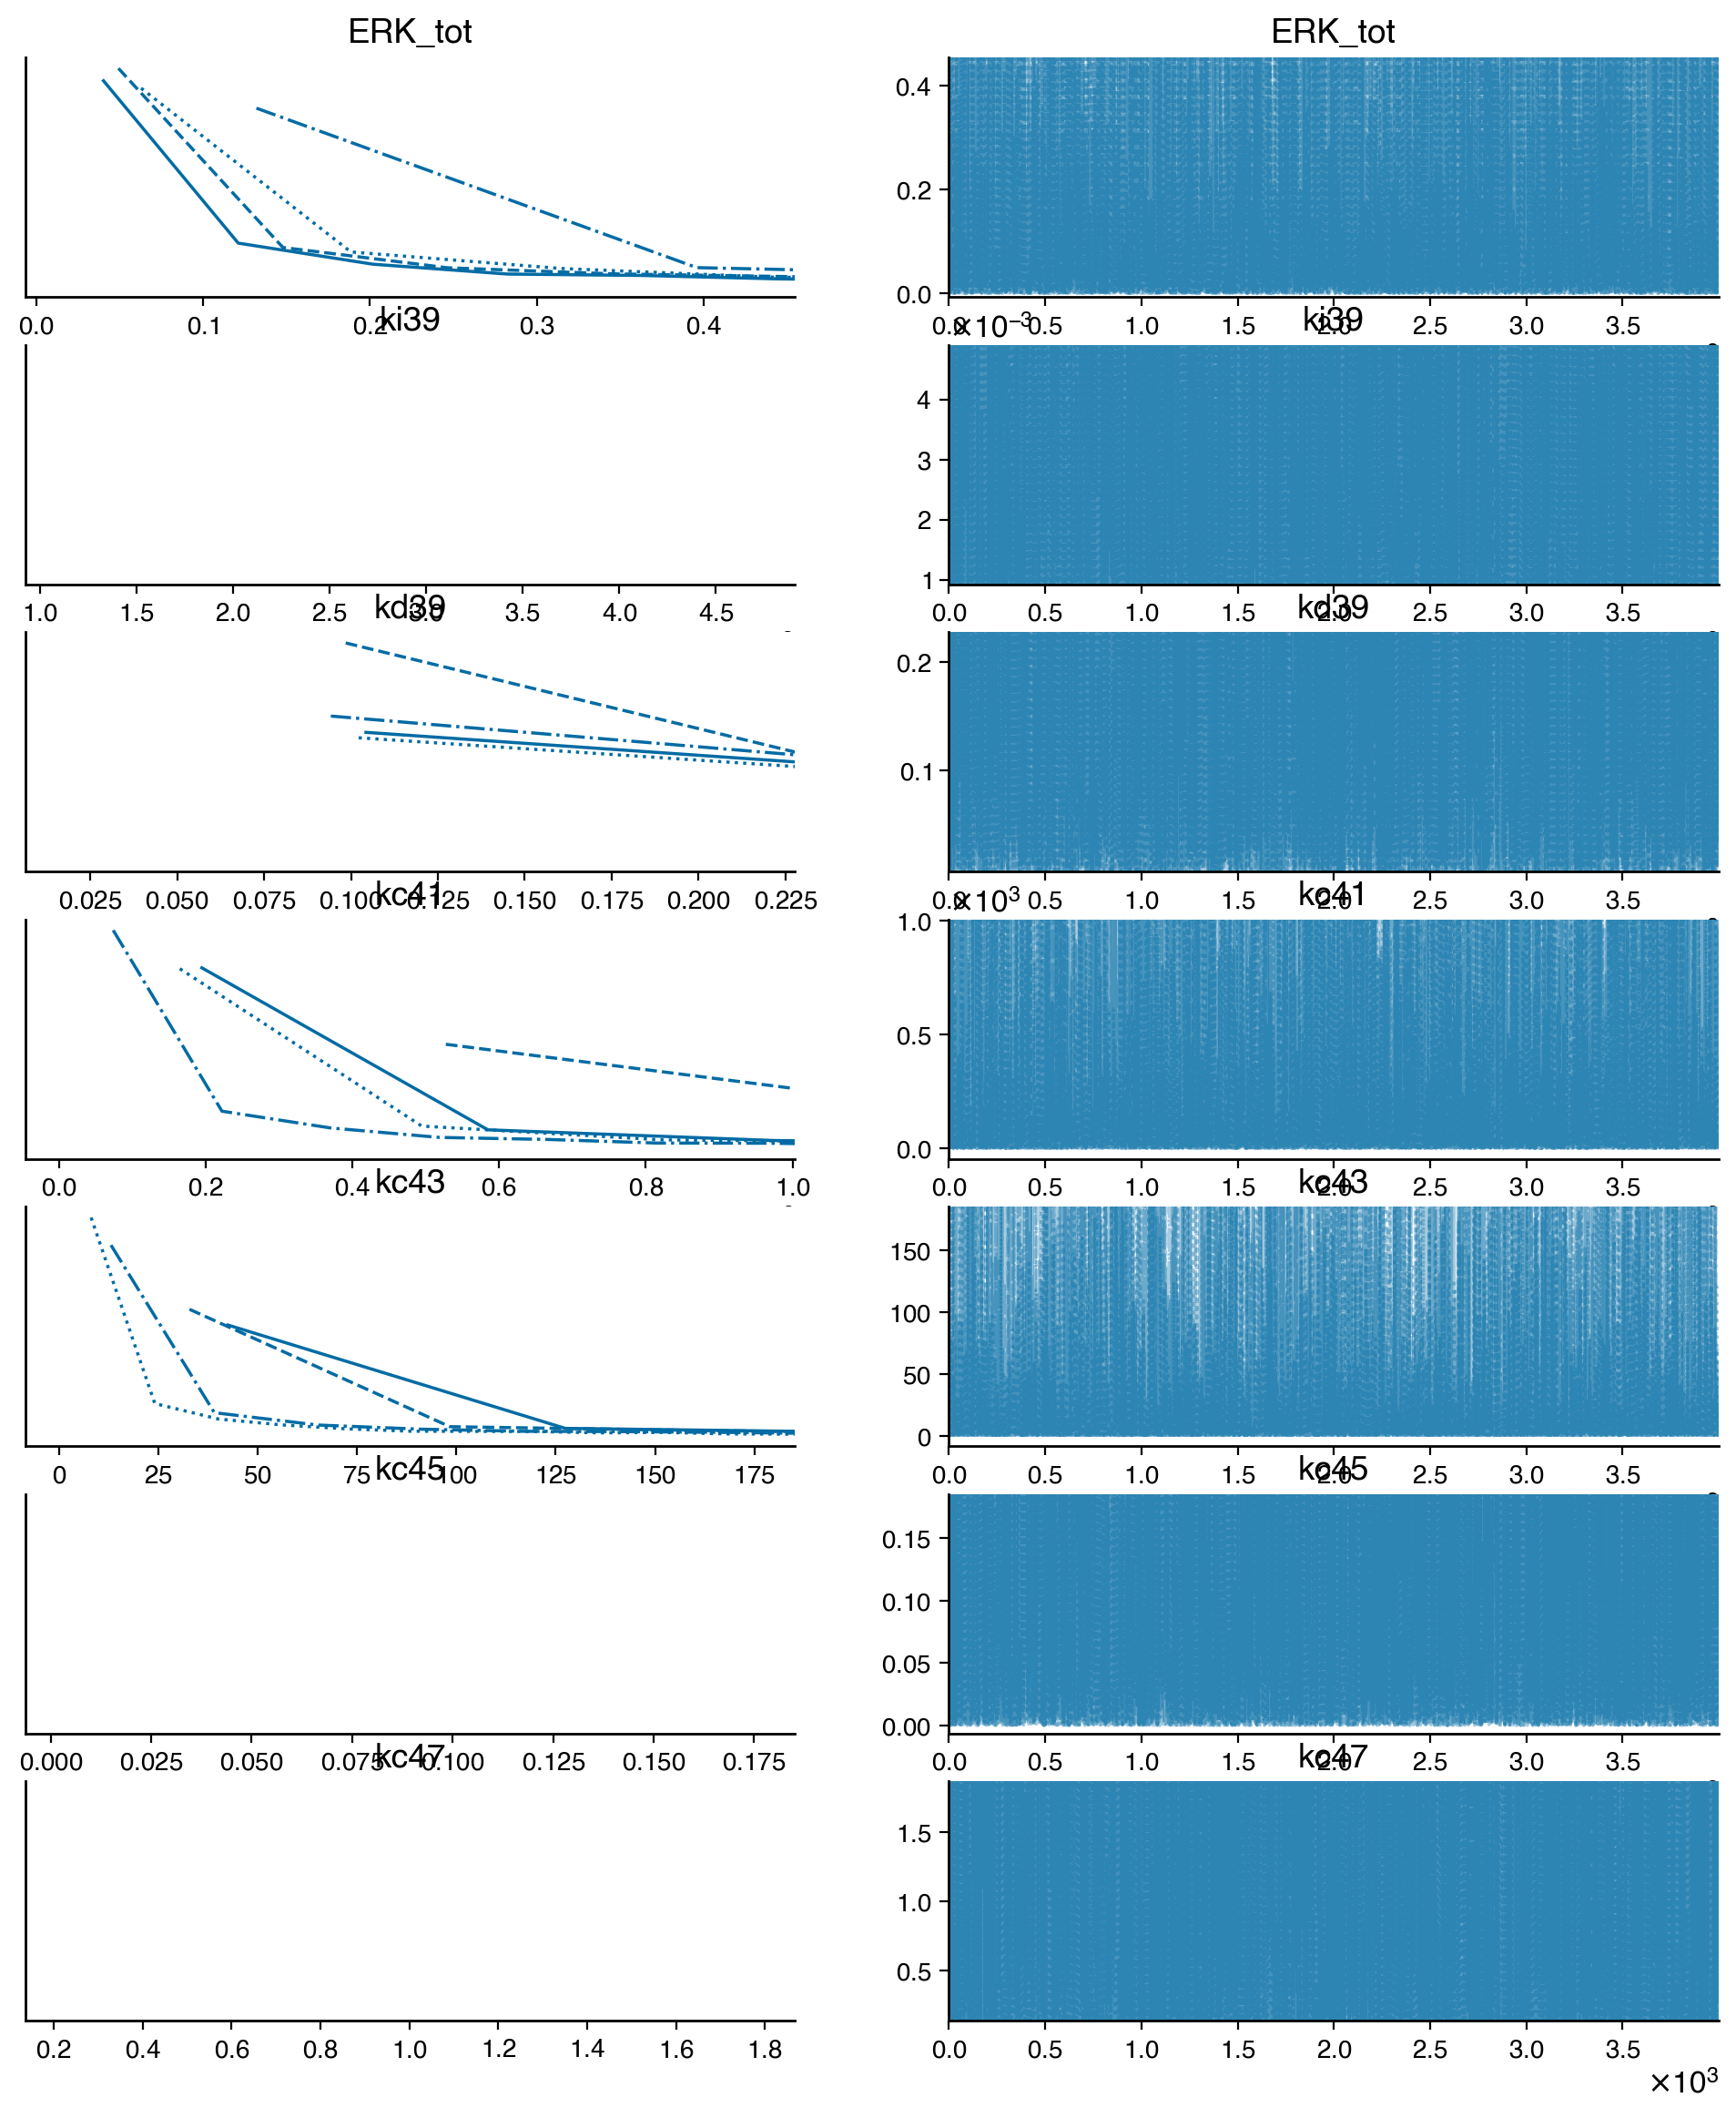

In [ ]:
axs = az.plot_trace(S_2014_idata)
for i,ax in enumerate(axs):
    ax[0].set_xlim(xlims[i])
    ax[1].set_ylim(xlims[i])

In [ ]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = plt_func.get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

In [ ]:
def create_posterior_predictive(model, posterior_idata, mapk_model_name, data, inputs, savedir, 
            seed=np.random.default_rng(seed=123)):
    """ Creates prior predictive samples plot of the stimulus response curve.
    """

    # sample from the prior predictive
    with model:
        posterior_predictive = pm.sample_posterior_predictive(posterior_idata, model=model, 
                                                              random_seed=seed)

    # extract llike values
    posterior_llike = np.squeeze(posterior_predictive.posterior_predictive['llike'].values)
    nsamples,ninputs=posterior_llike.shape
    # posterior_llike = np.reshape(posterior_llike, (nchains*nsamples, ninputs))

    # generate the plot
    fig, ax = plot_stimulus_response_curve(posterior_llike, data, inputs)

    # save the figure
    fig.savefig(savedir + mapk_model_name + '_posterior_predictive.pdf', 
                bbox_inches='tight', transparent=True)

    # save the samples
    np.save(savedir + mapk_model_name + '_posterior_predictive_samples.npy', posterior_llike)

    return fig, ax

Sampling: [llike]


(<Figure size 1200x1200 with 1 Axes>,
 <Axes: xlabel='EGF stimulus', ylabel='% maximal ERK activity'>)

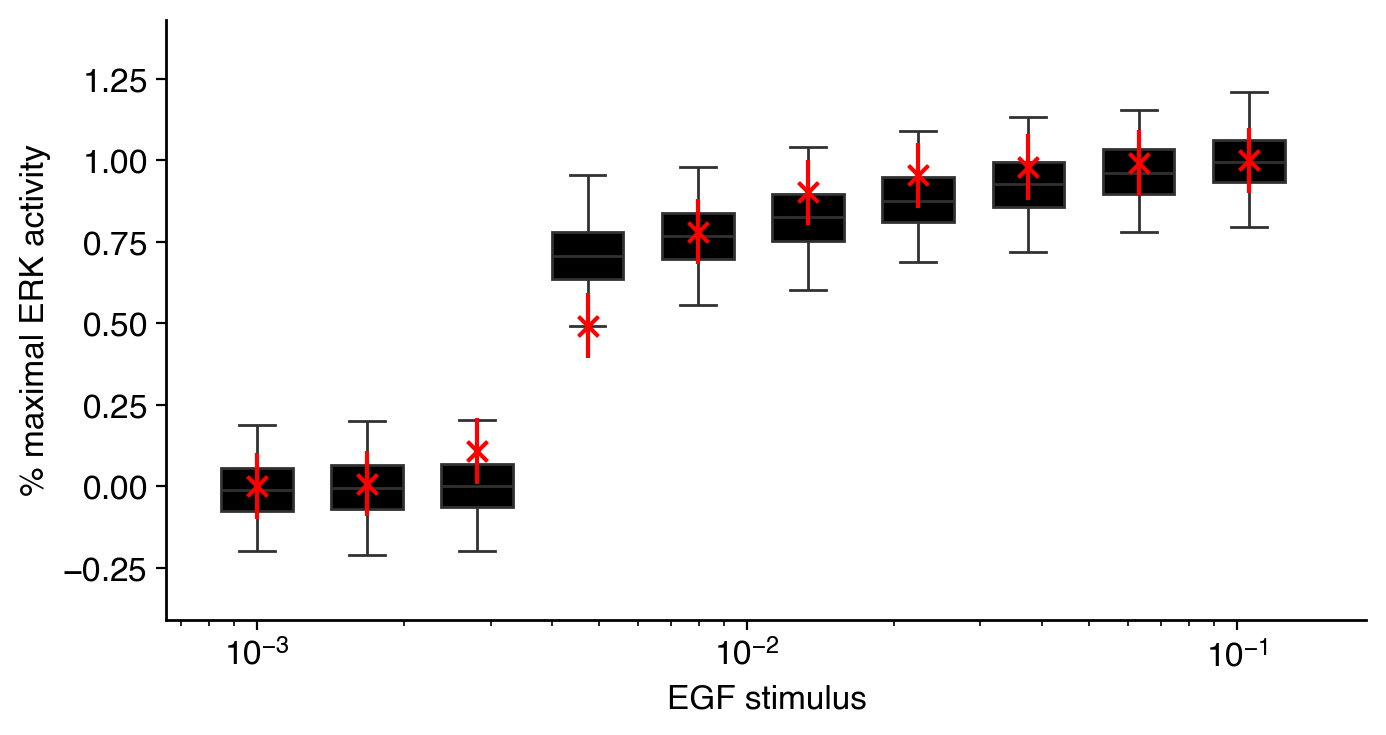

In [ ]:
create_posterior_predictive(pymc_model, idata, model_name, data, 
                                inputs, './')